# Storing each 50ms row as a seperate spectrum
50 ms row = 1102 samples

13 rows = 650ms

In [43]:
import scipy
import scipy.signal
import numpy as np
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [42]:
def restore(D, frame_size, hop_length, epochs=100, length=None):

    D = np.concatenate((np.zeros((D.shape[0], 1)), D, np.zeros((D.shape[0], 1))), axis=1)
    mag, _ = librosa.magphase(D)
    
    phase = np.exp(1.j * np.random.uniform(0., 2*np.pi, size=mag.shape))
    x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, length=length)
    
    for i in range(epochs):
        _, phase = librosa.magphase(librosa.stft(x_, n_fft=frame_size, hop_length=hop_length, center=False))
        x_ = librosa.istft(mag * phase, hop_length=hop_length, center=False, length=length)
        
    return x_[hop_length:-hop_length]

### Loading Sounds

In [2]:
names = {'Ba.wav', 'fa.wav', 'Ga.wav', 'Ma.wav', 'Ra.wav', 'Bu.wav', 'Ru.wav', 'mu.wav', 'fu.wav', 'Gu.wav'}
path = '/home/srg/Documents/MSU/EEG/data/sound_files/'
SR = 22050

Sounds = []
for name in names:
    Sounds.append(librosa.load(path + name, sr=SR)[0])

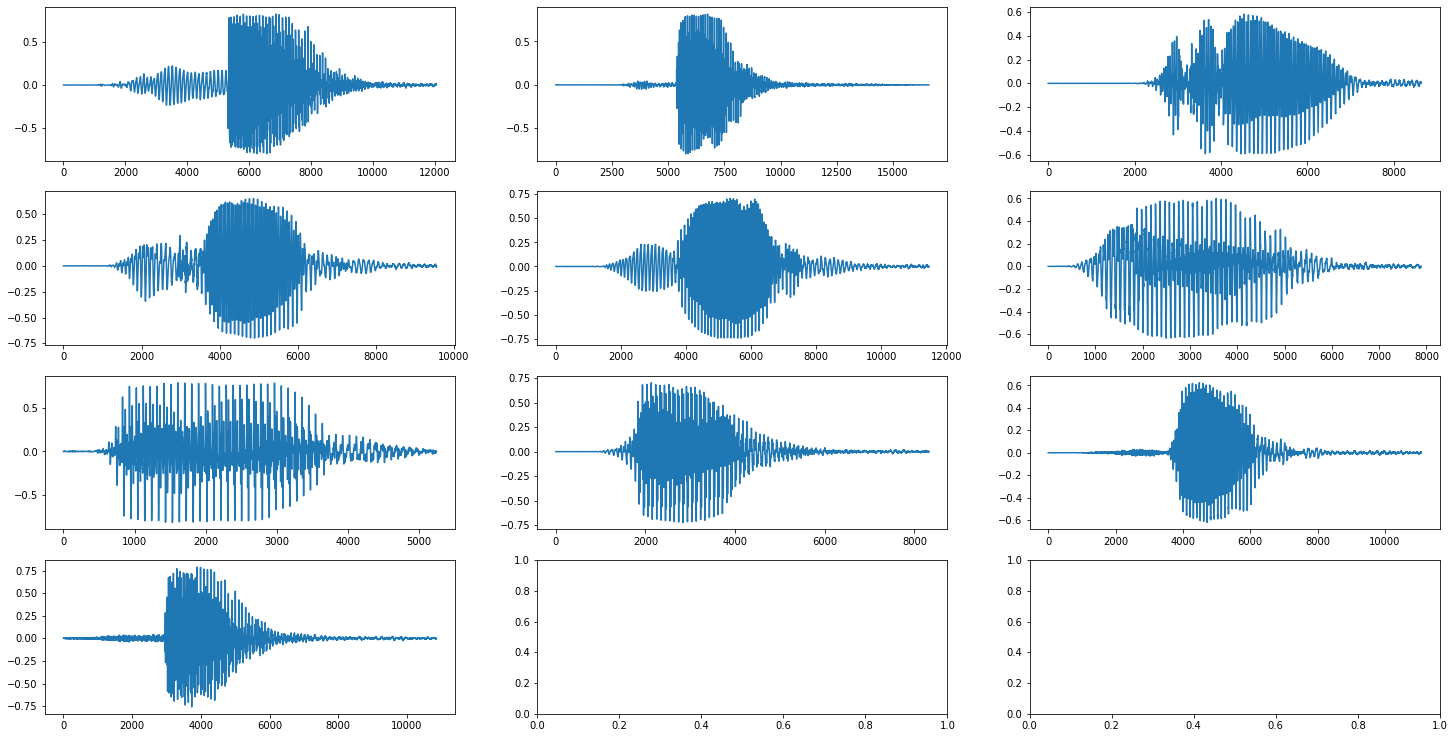

In [13]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(Sounds[3 * i + j])
        if 3 * i + j == 9:
            break

### Reshaping to 650 ms

In [8]:
Snd = np.empty((0, 14326))
for sig in Sounds:
    if sig.shape[0] <= 14326:
        mod = sig.shape[0] % 2
        tmp = np.pad(sig, ((14326 - sig.shape[0]) // 2 + mod,
                           (14326 - sig.shape[0]) // 2), 'constant', constant_values=(0, 0))
        Snd = np.append(Snd, tmp.reshape(1, -1), axis=0)
    else:
        Snd = np.append(Snd, sig[:14326].reshape(1, -1), axis=0)
Snd = Snd.reshape(10, 13, 1102)
Snd.shape

(10, 13, 1102)

### Computing spetrums

In [13]:
FRAME_SIZE = 1102
SR = 22050
HOP_LENGTH = 1102 * 2

In [73]:
Specs = np.empty((0, 552))
for syl in Snd:
    for row in syl:
        x = np.abs(librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False))
        Specs = np.append(Specs, x.T, axis=0) # x is (552, 1)
Specs = Specs.reshape(10, 13, 552)
Specs.shape

(10, 13, 552)

### Back to sound

In [74]:
Signal = np.empty((0, 1102))
for spec in Specs.reshape(130, 552):
    x_ = restore(spec.reshape(552, 1), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)

#### Plotting restored sounds

In [95]:
cutSignal = Signal.reshape(10, -1)
cutSignal = cutSignal * (cutSignal < 1) * (cutSignal > -1)

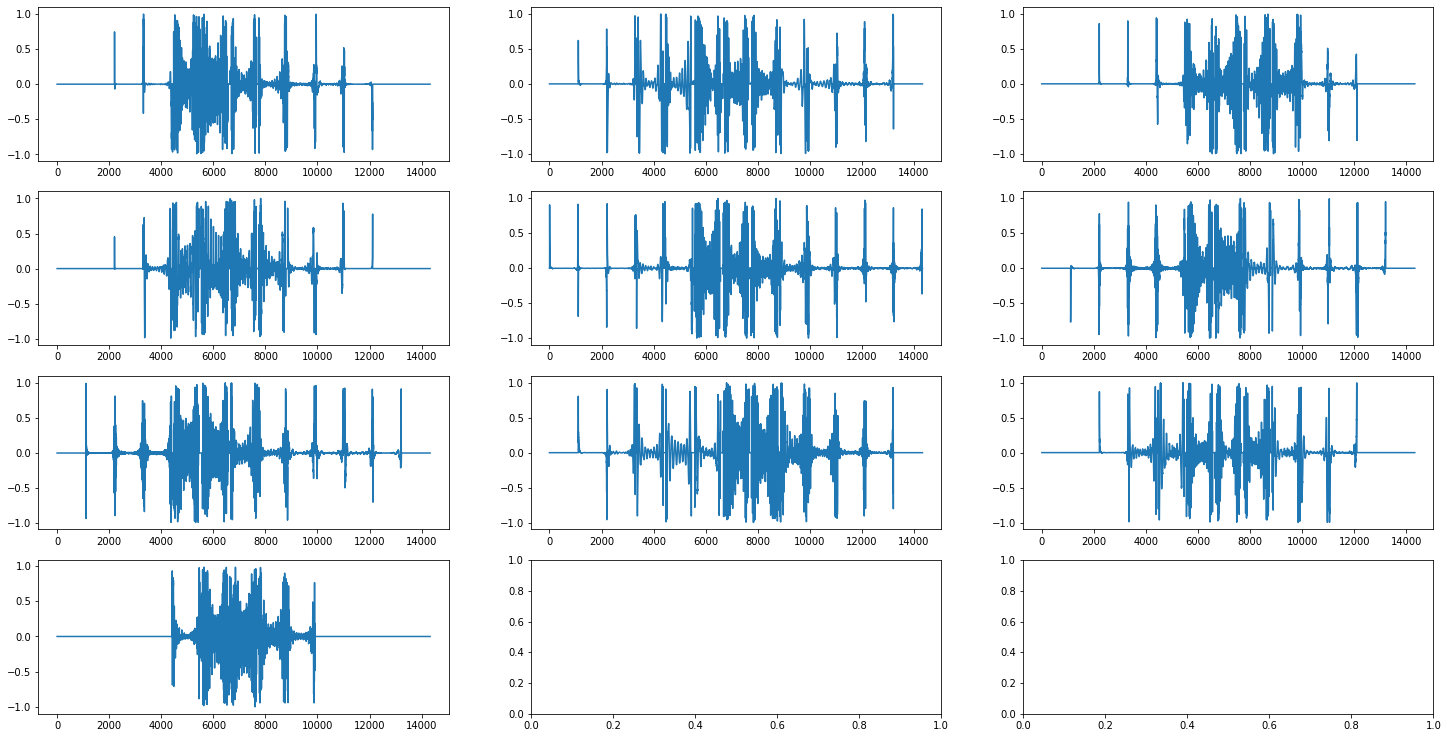

In [31]:
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(cutSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### Analysis

#### Plotting windows for 1st syllable

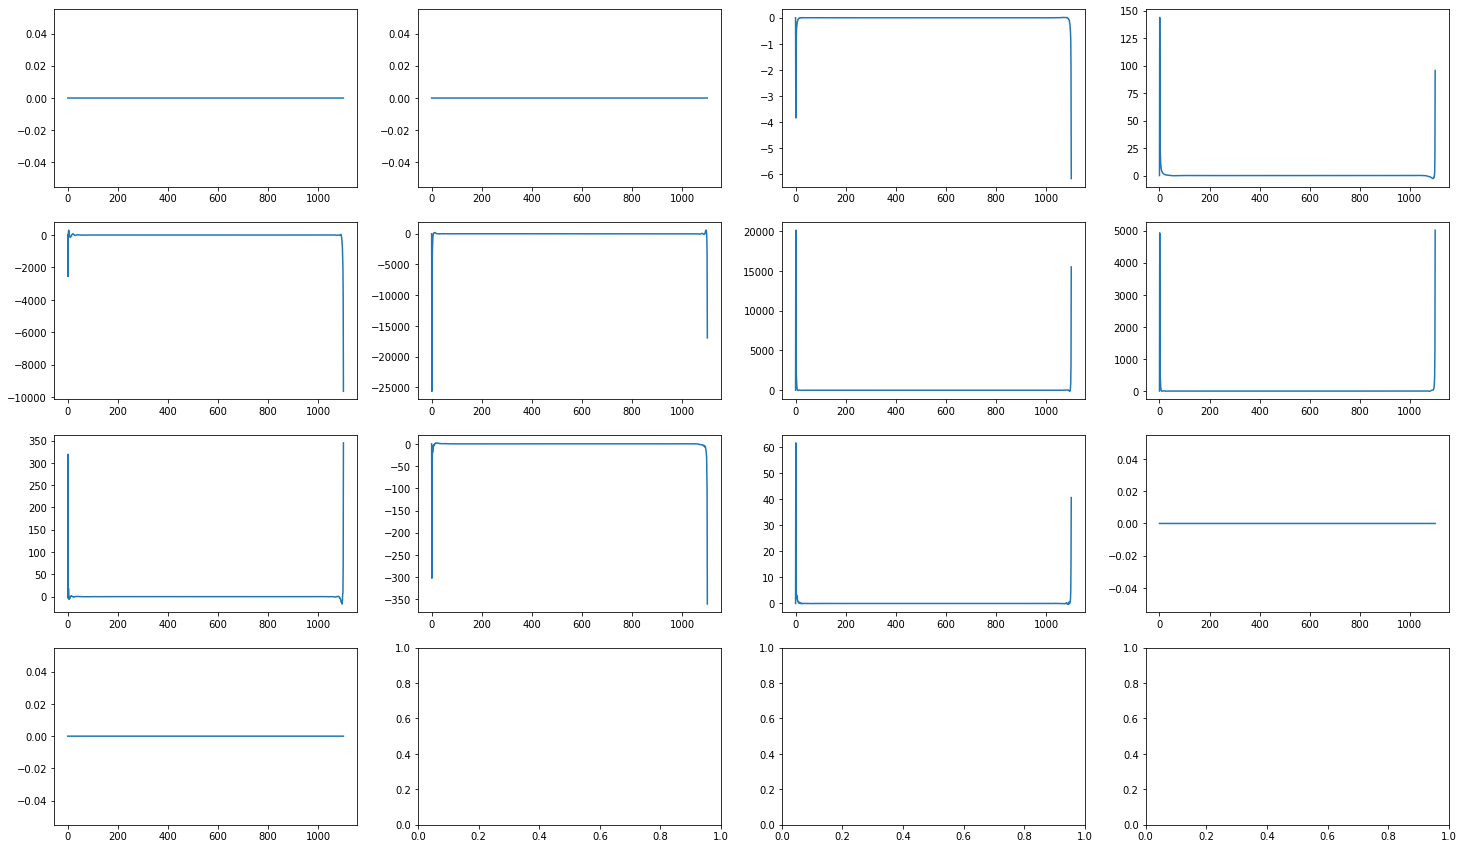

In [75]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

#### Shutting off first and last 20 samples

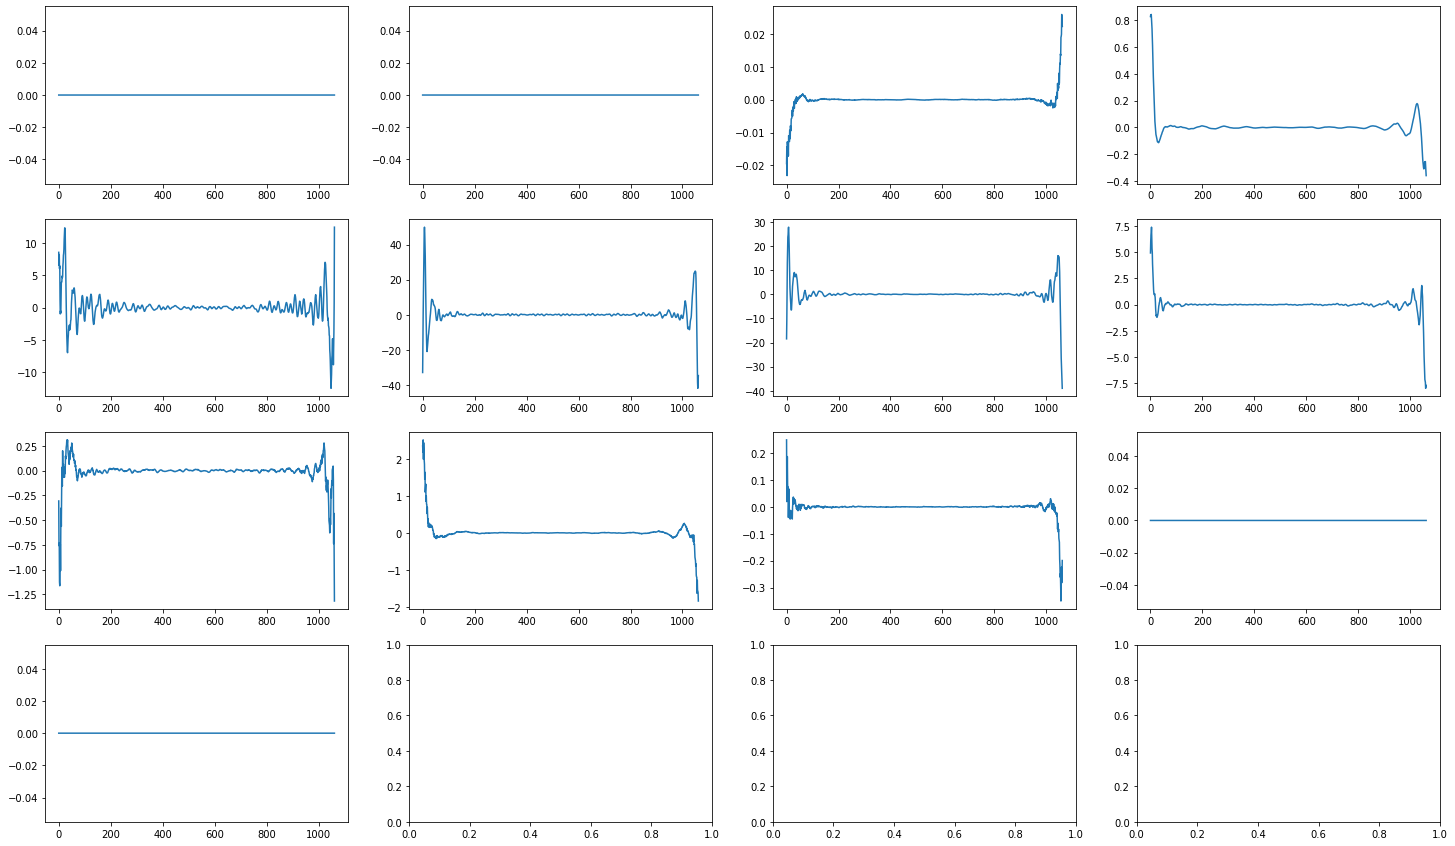

In [37]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j][20:-20])
        if 4 * i + j == 12:
            break

In [40]:
# Saving...

save = np.empty(0)
for i in range(4):
    for j in range(4):
        save = np.append(save, Signal[4 * i + j][20:-20], axis=0)
        if 4 * i + j == 12:
            break

scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, save)
# Result: bad quality as expected

In [96]:
x = cutSignal[0][(cutSignal[0] > 0.05) | (cutSignal[0] < -0.05)]
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)
x.shape

(3039,)

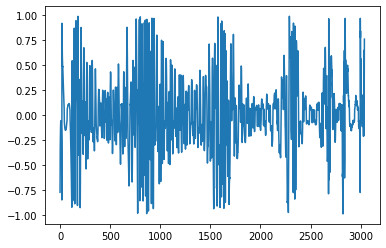

In [97]:
plt.plot(x)

# 50 ms row -> 10 frames

In [101]:
FRAME_SIZE = 346
SR = 22050
HOP_LENGTH = 84

In [102]:
Snd.shape

(10, 13, 1102)

In [106]:
Specs = np.empty((0, 1740))
for syl in Snd:
    for row in syl:
        x = np.abs(librosa.stft(row, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, center=False)).reshape(1, -1)
        Specs = np.append(Specs, x, axis=0)
Specs = Specs.reshape(10, 13, 1740)
Specs.shape

(10, 13, 1740)

In [107]:
Signal = np.empty((0, 1102))
for spec in Specs.reshape(130, 1740):
    x_ = restore(spec.reshape(174, 10), frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, epochs=10)
    Signal = np.append(Signal, x_.reshape(1, -1), axis=0)
x = np.squeeze(Signal.reshape(-1, 1))
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/1.wav', SR, x)

### 10 syllable plots

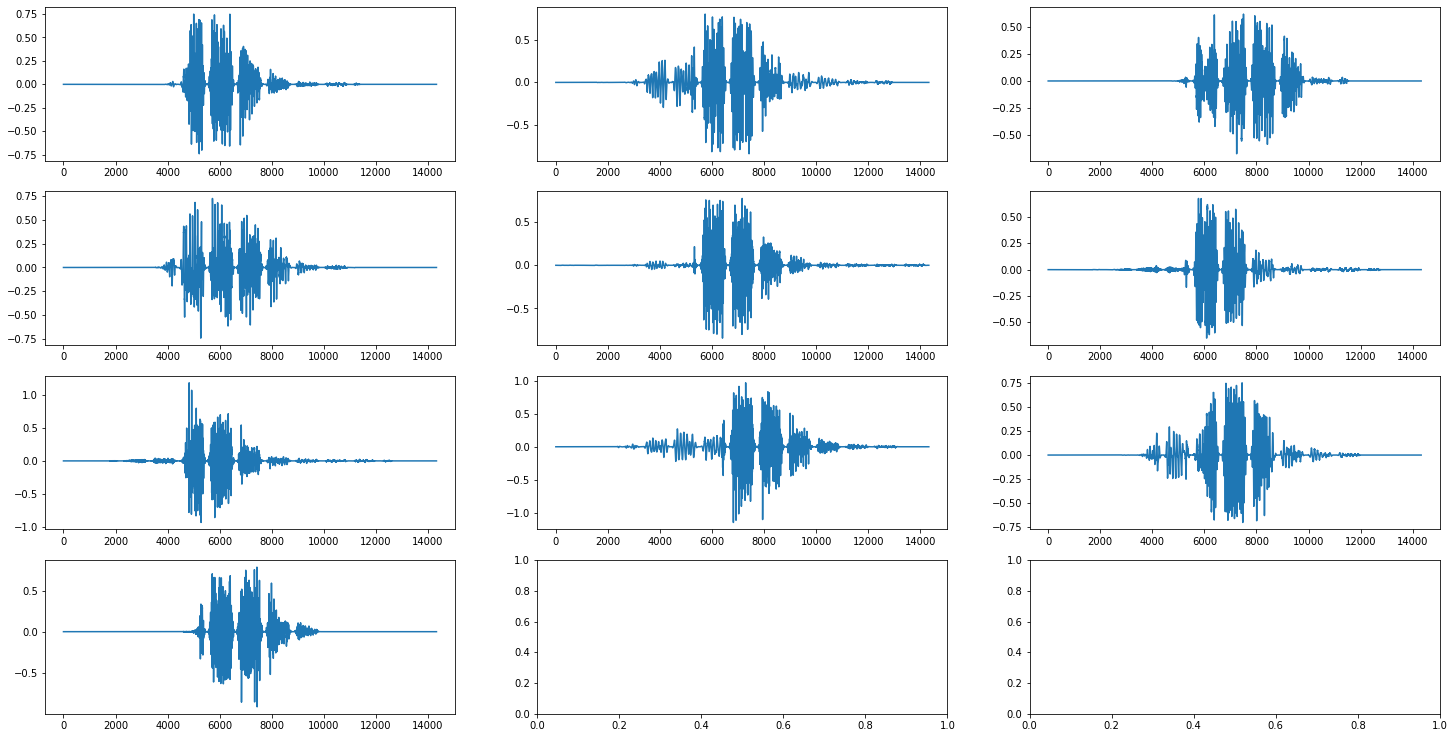

In [108]:
pltSignal = Signal.reshape(10, -1)
fig, axes = plt.subplots(figsize=(25, 13), nrows=4, ncols=3)
for i in range(4):
    for j in range(3):
        axes[i][j].plot(pltSignal[3 * i + j])
        if 3 * i + j == 9:
            break

### 1st syllable (all 13 rows)

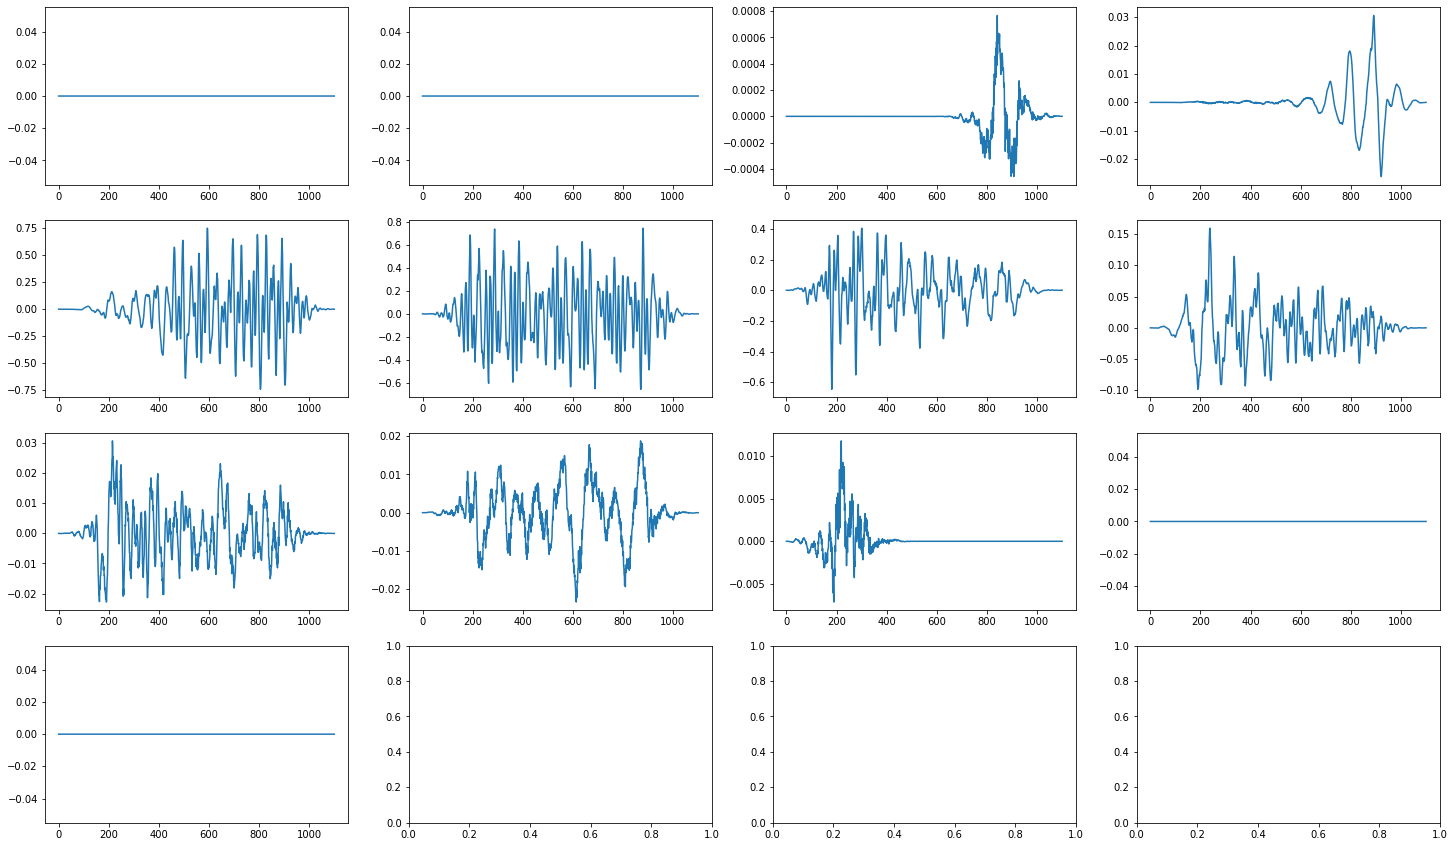

In [119]:
fig, axes = plt.subplots(figsize=(25, 15), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        axes[i][j].plot(Signal[4 * i + j])
        if 4 * i + j == 12:
            break

In [136]:
### Saving filtered file

save = np.empty(0)
for i in range(130):
    save = np.append(save, Signal[i][110:-110], axis=0)
    
scipy.io.wavfile.write('/home/srg/Documents/MSU/EEG/data/50ms/cut.wav', SR, save)

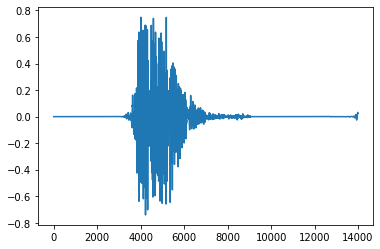

In [137]:
plt.plot(save[:14000])